# Comparison of BrainAges

Comparison of BrainAge deltas for discrimiantion between stable MCI and progressive MCI. These BrainAges are based on structural brain data and neuropsych test. These are also compared to using features directly.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.stats import kruskal, pearsonr

np.random.seed(0)

# Limiting who is a stableMCI and a progressiveMCI
stable_time = 3 # Only stable if hasn't converted in 3 years
progress_time = 3

# Use homogenized data
COMBAT = False

# Confidence Interval to use
ci_val = 0.95

# Threshold to binarize Logitisc regression classifiers
thr = 0.5 

# Number of splits for CV
cv_splits = 5

In [2]:
# Load data
if not COMBAT:
    fname = 'adni_brainage'
else:
    fname = 'adni_brainage_homogenisation'

df = pd.read_csv('../DATA/%s.csv' % fname, index_col=0)
df_smci = df[df['TYPECONVERSOR']==2.0]
df_pmci = df[df['TYPECONVERSOR']==5.0]

# Merge with all features
if not COMBAT:
    fname = 'adni_full_data'
else:
    fname = 'adni_full_data_for_homogenisation'
df_full = pd.read_csv('../DATA/%s.csv' % fname, index_col=0)
df_smci = df_smci.merge(df_full, on=['RID', 'TYPECONVERSOR'])
df_pmci= df_pmci.merge(df_full, on=['RID', 'TYPECONVERSOR'])

# Remove thoe smci who have not had more than x years of follow up
if stable_time is not None:
    df_smci = df_smci[df_smci['TIME2CONVERSION']>stable_time]
if progress_time is not None:
    df_pmci = df_pmci[df_pmci['TIME2CONVERSION']<progress_time]

# Subsample to balance (if homogenisation too few sample to need balancing)
if not COMBAT:
    df_smci = df_smci.sample(n=len(df_pmci), random_state=0)

# Create labels
Y_smci = np.zeros(len(df_smci))
Y_pmci = np.ones(len(df_pmci))
Y = np.concatenate([Y_smci, Y_pmci])

def plot_roc(X, Y, name):
    
    #instantiate the model
    log_regression = LogisticRegression()

    #arrays to store all values
    accs = []
    aucs = []
    spes = []
    sens = []
    y_preds = np.empty(shape=Y.shape)
    
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
    
        #fit the model using the training data
        log_regression.fit(X_train,y_train)

        #use model to predict probability of tests
        y_pred = log_regression.predict_proba(X_test)[::,1]
        y_preds[test_index] = y_pred

        #calculate AUC of model
        auc = roc_auc_score(y_test, y_pred)
        aucs.append(auc)
        
        # Calculate relevant metrics
        acc = accuracy_score(y_test, y_pred>thr)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred>thr).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fp)
        accs.append(acc)
        sens.append(sensitivity)
        spes.append(specificity)

    # Compute confidence intervals
    ci_accs = st.t.interval(alpha=ci_val, df=len(accs)-1, loc=np.mean(accs), scale=st.sem(accs))
    ci_aucs = st.t.interval(alpha=ci_val, df=len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
    ci_sens = st.t.interval(alpha=ci_val, df=len(sens)-1, loc=np.mean(sens), scale=st.sem(sens))
    ci_spes = st.t.interval(alpha=ci_val, df=len(spes)-1, loc=np.mean(spes), scale=st.sem(spes))
        
    # Compute ROC curve and ROC area for all data
    fpr, tpr, thrs= roc_curve(Y, y_preds)
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve ( area = %0.3f [%.3f-%.3f] )" 
                                                         % (np.mean(aucs), ci_aucs[0], ci_aucs[1]))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC %s" % name)
    plt.legend(loc="lower right")
    plt.text(0.4, 0.15, ' Accuracy: %.3f [%.3f-%.3f] \n Sensitivity: %.3f [%.3f-%.3f] \n Specificity %.3f [%.3f-%.3f]' % 
                         (np.mean(accs), ci_accs[0], ci_accs[1], 
                          np.mean(sens), ci_sens[0], ci_sens[1],
                          np.mean(spes), ci_spes[0], ci_spes[1]), fontsize=12)

### BrainAges

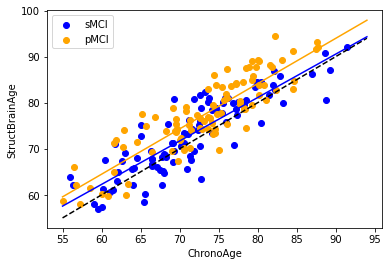

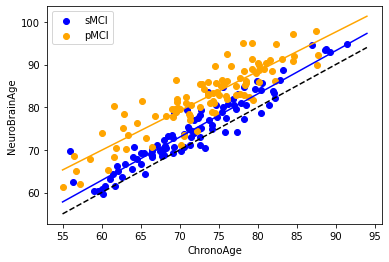

In [3]:
# Look at correlation between chronological age and calculated ages

for BrainAge_type in ['StructBrainAge', 'NeuroBrainAge']:
    chronoage_smci = df_smci['AGE'].to_numpy()
    BrainAge_smci = df_smci[BrainAge_type].to_numpy()
    chronoage_pmci = df_pmci['AGE'].to_numpy()
    BrainAge_pmci = df_pmci[BrainAge_type].to_numpy()

    # Calculate linear regression
    LR_smci = LinearRegression(fit_intercept='True')
    LR_smci.fit(chronoage_smci.reshape(-1, 1), BrainAge_smci)
    LR_pmci = LinearRegression(fit_intercept='True')
    LR_pmci.fit(chronoage_pmci.reshape(-1, 1), BrainAge_pmci)

    # Plot results
    age_range = np.arange(55, 95, 1)
    plt.plot(age_range, age_range, color='k', linestyle='dashed')
    plt.plot(age_range, LR_smci.predict(age_range.reshape(-1,1)), color='b')
    plt.plot(age_range, LR_pmci.predict(age_range.reshape(-1,1)), color='orange')
    plt.scatter(chronoage_smci, BrainAge_smci, label='sMCI', color='b')
    plt.scatter(chronoage_pmci, BrainAge_pmci, label='pMCI', color='orange')
    plt.xlabel('ChronoAge')
    plt.ylabel(BrainAge_type)
    plt.legend()
    plt.show()

### Comparison of deltas

We use the deltas calculated for each subject to train a logistic regressor to distinguish between sMCI and pMCI. We use structuralBrainDelta and neuroBrainDelta seperately, adding them and using them as individual features.

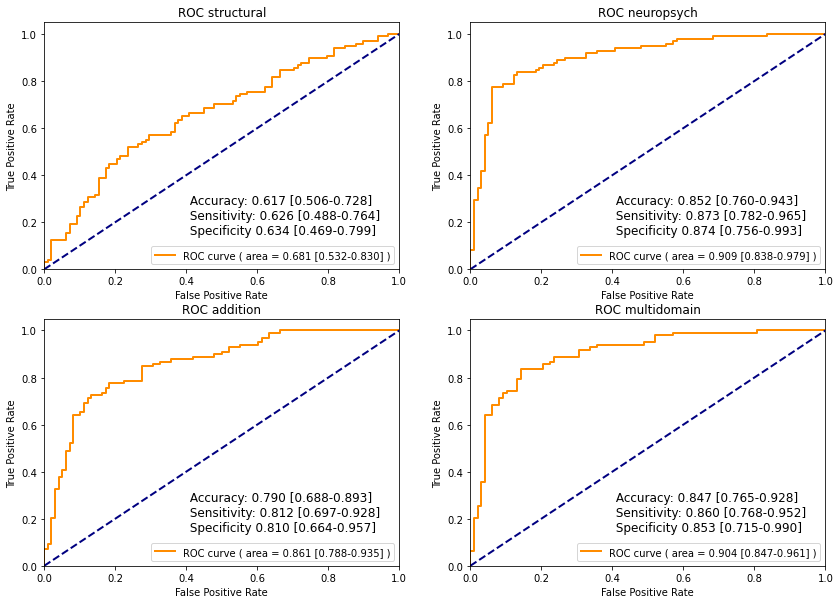

In [4]:
# Load structural
X_smci_struc = df_smci['StructBrainDelta'].to_numpy()
X_pmci_struc = df_pmci['StructBrainDelta'].to_numpy()
X_struc = np.concatenate([X_smci_struc, X_pmci_struc]).reshape(-1, 1)

# Load neuro
X_smci_neuro = df_smci['NeuroBrainDelta'].to_numpy()
X_pmci_neuro = df_pmci['NeuroBrainDelta'].to_numpy()
X_neuro = np.concatenate([X_smci_neuro, X_pmci_neuro]).reshape(-1, 1)

# Add both features
X_smci_add = X_smci_struc + X_smci_neuro
X_pmci_add = X_pmci_struc + X_pmci_neuro
X_add = np.concatenate([X_smci_add, X_pmci_add]).reshape(-1, 1)

# Join both features
X_smci_multi = np.stack([X_smci_struc, X_smci_neuro], axis=1)
X_pmci_multi = np.stack([X_pmci_struc, X_pmci_neuro], axis=1)
X_multi = np.concatenate([X_smci_multi, X_pmci_multi], axis=0)


# Run each through logistic regressor
names = ['structural', 'neuropsych', 'addition', 'multidomain']
Xs = [X_struc, X_neuro, X_add, X_multi]
plt.figure(figsize=(14,10))
for i, X in enumerate(Xs):
    plt.subplot(2,2,i+1)
    plot_roc(X, Y, names[i])
plt.show()

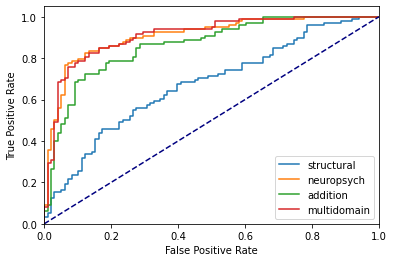

In [5]:
# Plot single ROC curve for all
for i, X in enumerate(Xs):
    log_regression = LogisticRegression()
    log_regression.fit(X,Y)
    y_preds = log_regression.predict_proba(X)[::,1]
    fpr, tpr, thrs= roc_curve(Y, y_preds)
    plt.plot(fpr, tpr, label=names[i])

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('figures/roc_curve.svg')
plt.show()

### Using features

Train a logistic regressor based on structural and neuropysch features directly.

In [6]:
# Features to use
f_neuro = ['MMSCORE', 'ADASSCORE', 'FAQTOTAL', 'MOCASCORE', 'ADNI_MEM', 'ADNI_EF']
f_struc = ['GM', 'WM', 'vscf', 'pgrey', 
        'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']
f_all = [*f_struc, *f_neuro]

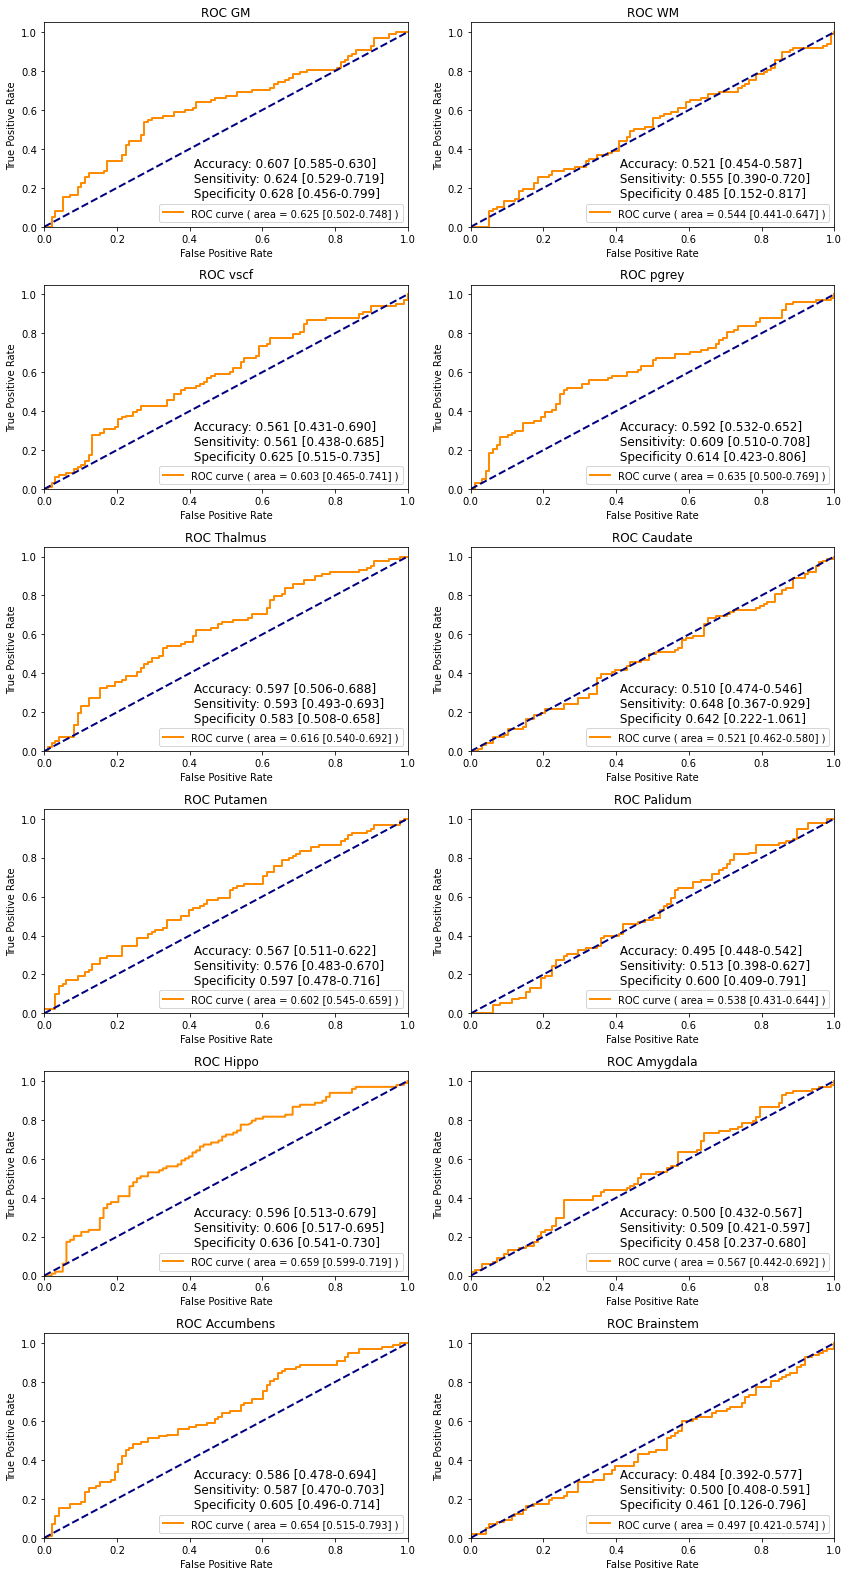

In [7]:
# Individual preidcitve power of each structural feature
plt.figure(figsize=(12,22))
for i, f in enumerate(f_struc):
    plt.subplot(6,2,i+1)
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci]).reshape(-1, 1)
    
    # Apply scaler to features
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # Plot ROC
    plot_roc(X, Y, f)
    
plt.tight_layout()
plt.show()

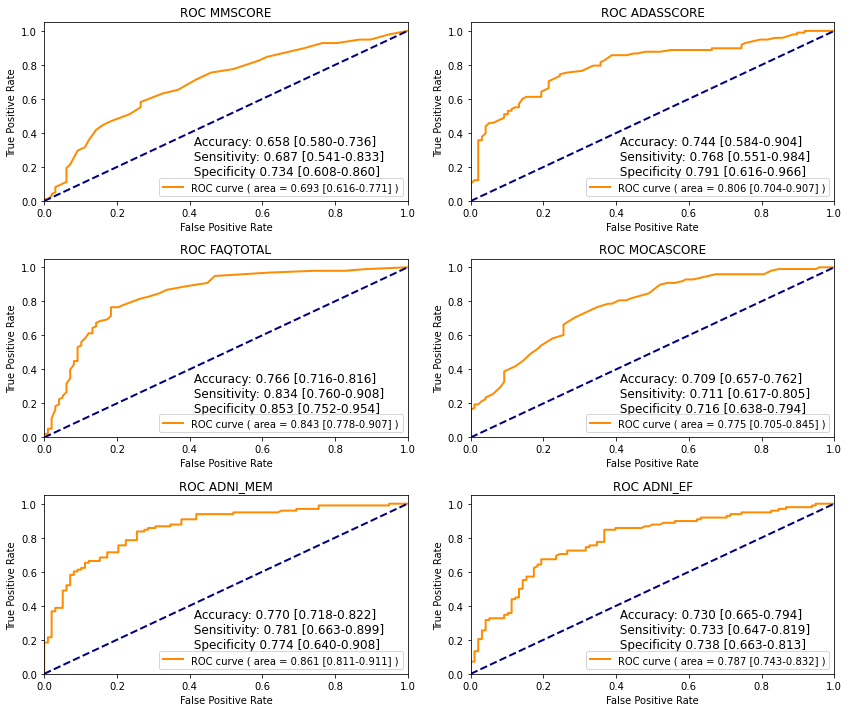

In [8]:
# Individual preidcitve power of each neuropsych feature
plt.figure(figsize=(12,10))
for i, f in enumerate(f_neuro):
    plt.subplot(3,2,i+1)
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci]).reshape(-1, 1)
    
    # Apply scaler to features
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # Plot ROC
    plot_roc(X, Y, f)
    
plt.tight_layout()
plt.show()

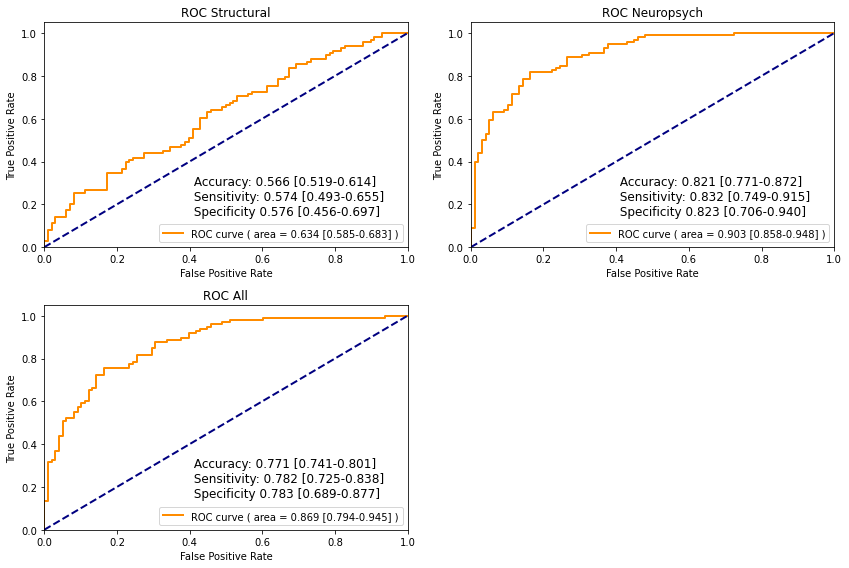

In [9]:
# Run through possible combinations
features = [f_struc, f_neuro, f_all]
names = ['Structural', 'Neuropsych', 'All']
plt.figure(figsize=(12,8))
for i, f in enumerate(features):
    plt.subplot(2,2,i+1)
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci])
    
    # Apply scaler to features
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # Plot ROC
    plot_roc(X, Y, names[i])

plt.tight_layout()
plt.show()

None of the logistic regression classifiers is able to outperform out brainAge delta model.

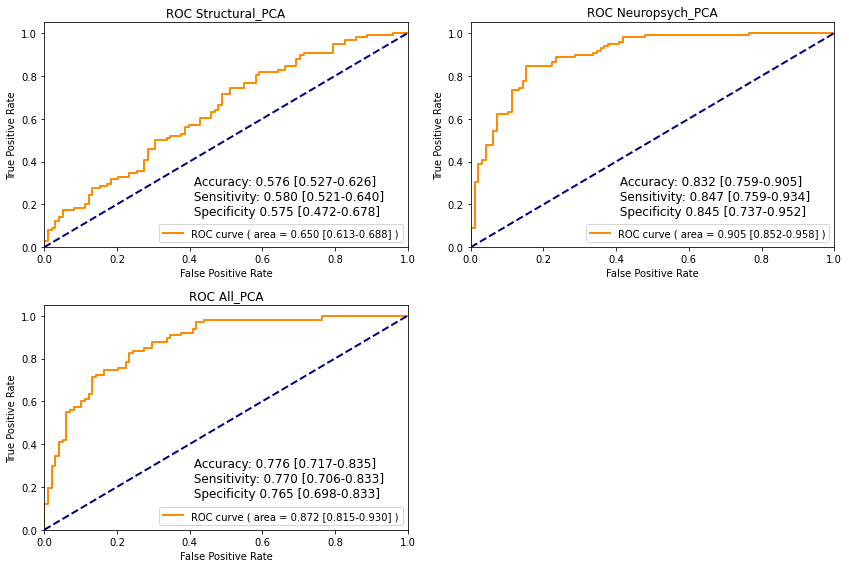

In [10]:
# Apply PCA to see if performance increases
df_cn = df_full[df_full['TYPECONVERSOR']==1.0]

# Run through possible combinations
features = [f_struc, f_neuro, f_all]
names = ['Structural_PCA', 'Neuropsych_PCA', 'All_PCA']
plt.figure(figsize=(12,8))
for i, f in enumerate(features):
    plt.subplot(2,2,i+1)
    
    # Fit PCA
    X_cn = df_cn[f].to_numpy()
    normalize_transform = StandardScaler().fit(X_cn)
    X_cn_norm = normalize_transform.transform(X_cn)
    
    # Choose number of components that give 90% of explained variance
    pca_transform = PCA(n_components=0.9).fit(X_cn_norm)
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci])
    
    # Apply transformation to features
    X = pca_transform.transform(normalize_transform.transform(X))
    
    # Plot ROC
    plot_roc(X, Y, names[i])

plt.tight_layout()
plt.show()

PCA does very slightly increase performance. The improvment is small since almost all components are needed to explain all the variance. The performance is still lower than using NeuropsychBrainAge gaps.

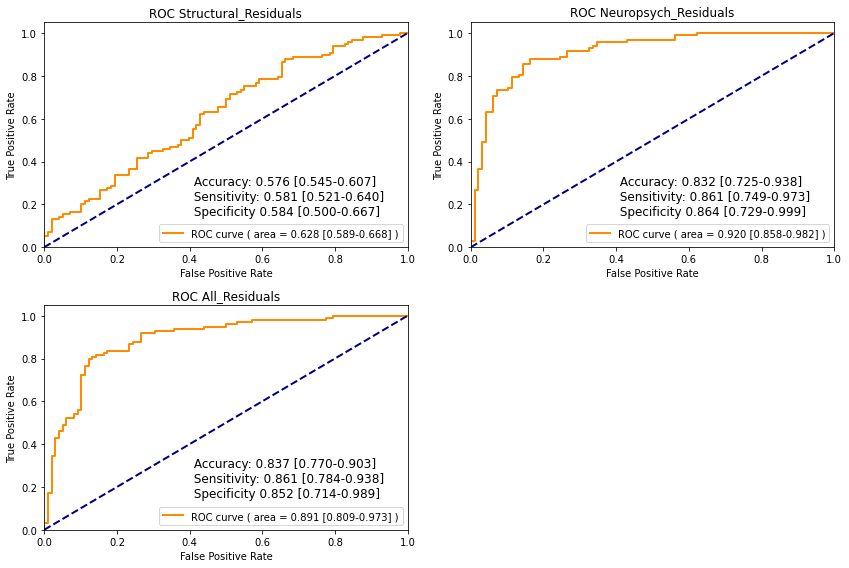

In [11]:
# Apply removal of covariates to see if performance increases
covariates = ['AGE', 'Female', 'Male', 'PTEDUCAT']
cov_cn = df_cn[covariates].copy()

# Run through possible combinations
features = [f_struc, f_neuro, f_all]
names = ['Structural_Residuals', 'Neuropsych_Residuals', 'All_Residuals']
plt.figure(figsize=(12,8))
for i, f in enumerate(features):
    plt.subplot(2,2,i+1)
    
    # Fit covariates
    X_cn = df_cn[f].to_numpy()
    LR_cov = LinearRegression(fit_intercept='True')
    LR_cov.fit(cov_cn.to_numpy(), X_cn)
    X_cn = X_cn - LR_cov.predict(cov_cn.to_numpy())
    normalize_transform = StandardScaler().fit(X_cn)
    
    # Get covariates
    cov_smci = df_smci[covariates]
    cov_pmci = df_pmci[covariates]
    cov = np.concatenate([cov_smci, cov_pmci])
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci])
    
    # Apply residuals and normalize 
    X = X - LR_cov.predict(cov)
    X = normalize_transform.transform(X)
    
    # Plot ROC
    plot_roc(X, Y, names[i])

plt.tight_layout()
plt.show()

Regressing out covariates increases the performance of the model. Altough the AUC is higher for the Neuropsych_Residuals model it stil has lower accuracy, sensitivity and specificity.

### Decission Tree

Clinicians normally favor decision trees for their interpretability. We train a decision tree classifier to see if better performance is achieved than with our brainAge metrics. 

In [12]:
# Run through possible combinations
features = [f_struc, f_neuro, f_all]
names = ['Structural', 'Neuropsych', 'All']

print('Accuracy of Decision Tree')
for i, f in enumerate(features):    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci])
    
    # Create Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=0)
    vals = cross_val_score(clf, X, Y, cv=5)
    ci = st.t.interval(alpha=ci_val, df=len(vals)-1, loc=np.mean(vals), scale=st.sem(vals))
    print('%s: %.3f [%.3f-%.3f]' % (names[i], np.mean(vals), ci[0], ci[1]))

Accuracy of Decision Tree
Structural: 0.582 [0.481-0.682]
Neuropsych: 0.781 [0.636-0.926]
All: 0.750 [0.687-0.813]


Decision trees perform worse than our logistic regressor based on brainAge deltas. 